# General Instructions

Students are allowed to work on this exercise in pairs. Make sure you have formed a group in Canvas with your partner. Each student is responsible for following the [Code of Conduct](https://kth.instructure.com/courses/32018/pages/code-of-conduct). In particular (1) All members of a group are responsible for the group's work, (2) Every student shall honestly disclose any help received and sources used, and (3) Do not copy from other people's solutions.

If you need assistance with the exercise, you are encouraged to post a question to the appropriate [Discussion Topic](https://kth.instructure.com/courses/32018/discussion_topics) or sign up for a help session.

<br>

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and delete the `raise NotImplementedError()` once you have implemented the solution

<br>

You should not import any libraries on top of the ones included in the assignment. Derivation questions can be answered using $\LaTeX$, or you may upload an image of your derivation. To do so in *Google Colab* simply create a text cell, click on the `insert image` icon, and upload an image to the notebook as we have demonstrated below.

<br>

**Submission** - once you have completed the exercise make sure everything runs as expected by going into `Runtime` -> `Restart and Run all` then download the notebook by clicking `file` -> `download` -> `download .ipynb`. Then **rename the file to include your name** (and **your partner's name** if you have one) as follows

<br>

`Ex??_LASTNAME_FIRSTNAME_and_LASTNAME_FIRSTNAME.ipynb`

<br>

where you replace `??` with the correct exercise number. If you are working alone you do not need to include a partner name. Correctly naming the file and including your name (and your partner's) below is worth **1 point** - if you fail to correctly name the file or include your partner's name, *you will lose this point*.

<br>

Good luck!

# Name (1 pts)
**Fill in your name and your partner's name below** (and name the `.ipynb` file correctly): <font color="red"> (1 Point) </font>

YAP, MING YANG

# Exercise 8: Machine learning and information theory (16 points)

In this exercise, you will implement and study the behaviour of a number of concepts from module 8 in the course. The exercise contains two parts:
1. Implementing basic concepts from information theory
2. Implementing, training, and tuning decision trees

_Important:_<br/>
Make sure you have [graphviz](https://graphviz.org/download/) installed. It will be used to visualise decision trees. It is already available in the Google Colab environment.

In [ ]:
%%capture
!pip install numpy matplotlib seaborn scikit-learn scipy
!conda install -c conda-forge pydot graphviz -y

In [ ]:
# Useful imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import warnings
import pydot
from IPython.display import Image, display

from uuid import uuid4
from collections import Counter
from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import os

# Initial plotting function
def plot_function(function, inputs, title=None, ylabel=None):
    fig, ax = plt.subplots()
    ax.plot(inputs, function(inputs))
    if title:
        ax.set_title(title)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_xlabel("Probability of $x$")
    if ylabel:
        ax.set_ylabel(ylabel)
    plt.show()

## 8.1 General information theory (6.25 Points)

In this first part of the exercise, you will implement and play with a few information-theoretic concepts.

### Information content

The _Shannon information_ or _information content_ is a measure of how surprising an event is. It is given by the following formula
$$ I(x) = \log_2 \frac{1}{P(\boldsymbol x=x)}\ = - \log_2 P(\boldsymbol x=x) $$
Since we are using the 2-logarithm, this gives the entropy in bits.

Mathematically we see that something that is completely certain ($P(\boldsymbol x=x)=1$) has no new information in it at all ($I(x)=0$). According to the definition, the more unlikely an event is, the more information it contains. The Shannon information is therefore also known as the _surprisal_.

**8.1.1 Task:**<br/>
Implement a function, `information_content`, to compute the information content in bits according to the above formula, given the probability `p_x` of an event. <font color="red"> (1 point) </font>

_Hint:_<br/>
The 2-logarithm can be accessed through `np.log2`. This function also works on arrays.

***Something to think about:***
Consider a uniform categorical distribution over k possible outcomes. In which direction does the entropy of this distribution change as we increase k?



In [ ]:
def information_content(p_x):
    return -np.log2(p_x)

In [ ]:
assert information_content(0.5) == 1
assert round(information_content(0.01), 2) == 6.64

The code below plots a graph of the surprisal as a function the event probability.

In [ ]:
p_x = np.linspace(1, 0, 1001, endpoint=False)[1:] # Probabilities on (0, 1)
plot_function(information_content, p_x, title="Probability vs. information", ylabel="Information $I(x)$ (bits)")

### Entropy

The _information entropy_ or _Shannon entropy_ (often just “entropy”, for short) is perhaps the most widely used concept in information theory. It is defined as the expected information content of a random variable $\boldsymbol x$. The entropy in bits can be computed as follows
$$ H(\boldsymbol x) = \mathbb{E}_{\boldsymbol x} \left[ - \log_2 P(\boldsymbol x) \right] = - \sum_{x\in \Omega} P(\boldsymbol x=x) \log_2 P(\boldsymbol x=x)$$

***Something to think about:***
Why is cross entropy often used as a loss function in machine learning?
What is the principle of maximum entropy and its significance?

**8.1.2 Task:**<br/>
Implement the function `entropy_bernoulli` that computes the information entropy of a Bernoulli random variable $\mathbf x$, with the probability mass function
$$ P(\mathbf x=\mathrm x) = \begin{cases} \theta &\text{if $\mathrm x=1$}\\
1 - \theta &\text{if $\mathrm x=0$,}
\end{cases} $$
as a function of the success probability $\theta=$ `p_x`. `p_x` can be an array, in which case the each element is an different value of $\theta$ for which to compute the Bernoulli entropy. <font color="red"> (1 point) </font>

In [ ]:
def entropy_bernoulli(p_x):
    return p_x * information_content(p_x) + (1-p_x) * information_content(1-p_x)

In [ ]:
# Run pre-specified tests (do not edit)
assert entropy_bernoulli(0.5) == 1
assert np.round(entropy_bernoulli(0.001), 2) == 0.01

What happens if $\theta=0$?

In [ ]:
entropy_bernoulli(0)

It is likely that your function throws an error or returns a value like `nan` when you run the above code. This is because $-\log_2 P(\mathbf x=\mathrm x)\to\infty$ as $P(\mathbf x=\mathrm x)\to 0$. The entropy is thus a product of something that's zero and something that is infinite.

**8.1.3 Task:**<br/>
Let's call $P(\mathbf x=\mathrm x)=p$. Evaluate the limit $I(0)=\lim_{p\to 0} -p \ln p$ as $p$ approaches zero from above (i.e., $p>0$). Show your work in the below cell. <font color="red"> (1 point) </font>

_Note:_<br/>
It is not sufficient to just state the answer. You have to do a brief derivation based on what you learned in calculus class to show your work.

_Hint:_<br/>
There are many ways to do this. You can, for instance, use L'Hôpital's rule.

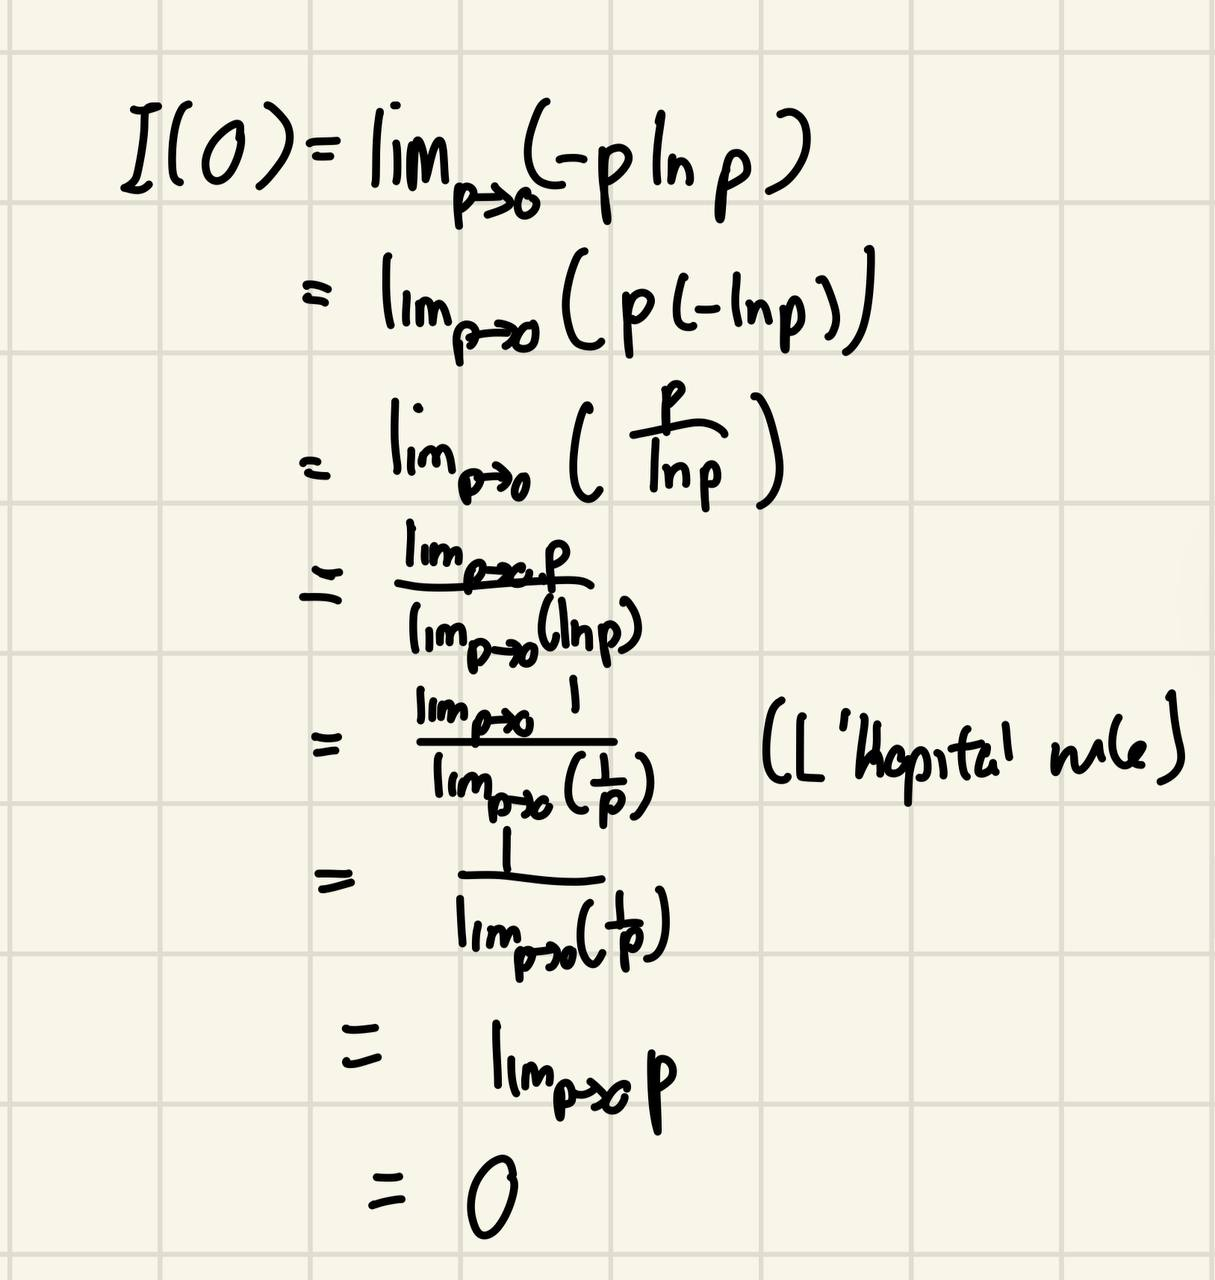

Now you both know why $\theta=0$ gave an error, and what the value should be in that case.

**8.1.4 Task:**<br/>
Implement a modified version of `entropy_bernoulli` that also handles the edge cases $\theta=0$ and $\theta=1$ correctly. <font color="red"> (1 point) </font>

_Hint:_<br/>
You can use the command `np.where` to give a special treatment to elements of `p_x` that satisfy a boolean condition of your choice. Even if your solution is correct, you may still see a runtime warning.

In [ ]:
def entropy_bernoulli(p_x):
    return np.where(np.logical_or(p_x == 0, p_x == 1), 0, p_x * information_content(p_x) + (1-p_x) * information_content(1-p_x))

In [ ]:
# Run pre-specified tests (do not edit)
assert entropy_bernoulli(0) == 0
assert entropy_bernoulli(1) == 0

Let's plot the information entropy as a function of $\theta\in[0,1]$:

In [ ]:
p_x = np.linspace(0, 1, 1001)
plot_function(entropy_bernoulli, p_x,
              "Entropy of a Bernoulli distributed random variable", "Information entropy $H(x)$ (bits)")

If you have done things right, you should see a roughly parabolic, upside down curve. But is it an actual parabola? Let's find out!

**8.1.5 Task:**<br/>
Derive an equation for the parabola $f(\mathrm x)$ that passes through the three points $(0,0)$, $(\frac{1}{2},1)$, and $(1,0)$. Show your solution and your work in the cell below. <font color="red"> (1 point) </font>

YOUR ANSWER HERE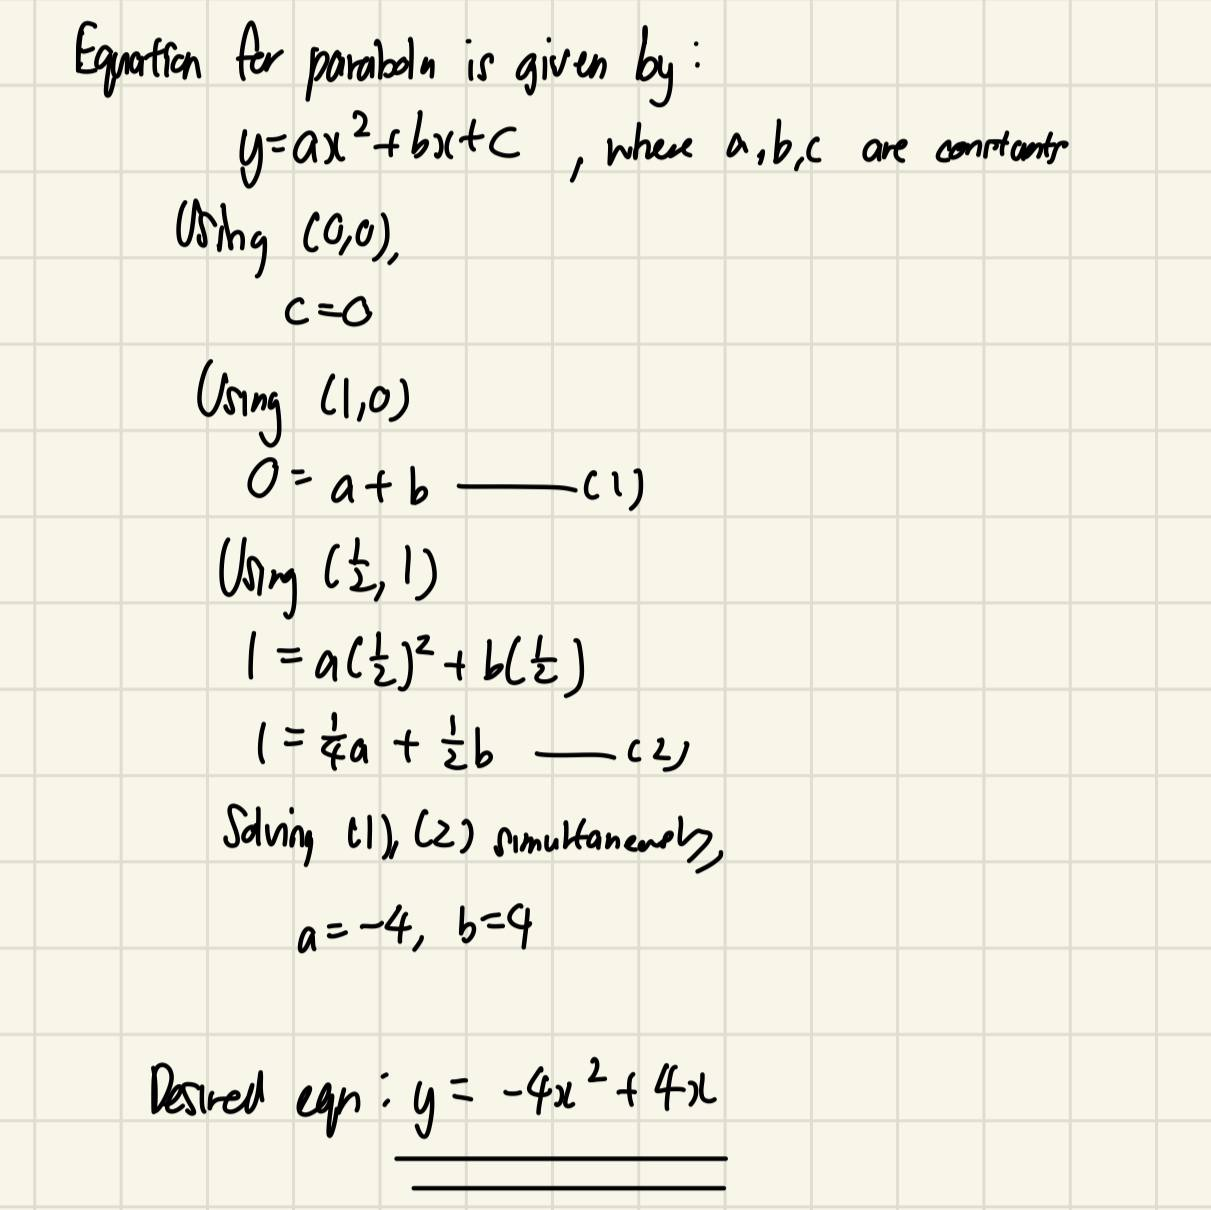

**8.1.6 Task:**<br/>
Plot the parabola you just derived on the interval $[0, 1]$, overlaid on the previous function `entropy_bernoulli` plotted on the same interval, so that you can compare the two curves. <font color="red"> (1 point) </font>

_Hint:_<br/>
You can borrow some plotting code from `plot_function` defined earlier.

In [ ]:
fig, ax = plt.subplots()
y_func = lambda x: -4 * x **2 + 4 * x
ax.plot(p_x, entropy_bernoulli(p_x), label = "Entropy Bernoulli")
ax.plot(p_x, y_func(p_x), label = "Parabola")
ax.legend()
plt.show()

It looks like the parabola always is below the information entropy $H$, although the difference is moderate.

Did you notice that the entropy in the plot never seems to go below zero? That is no coincidence.

**8.1.7 Task:**<br/>
Prove that $H(\boldsymbol x)\geq 0$ (entropy is never negative) for _any_ discrete random variable $\boldsymbol x$. <font color="red"> (1 point) </font>

_Hint:_<br/>
Use the fact that $0\leq P(\boldsymbol x)\leq 1$.

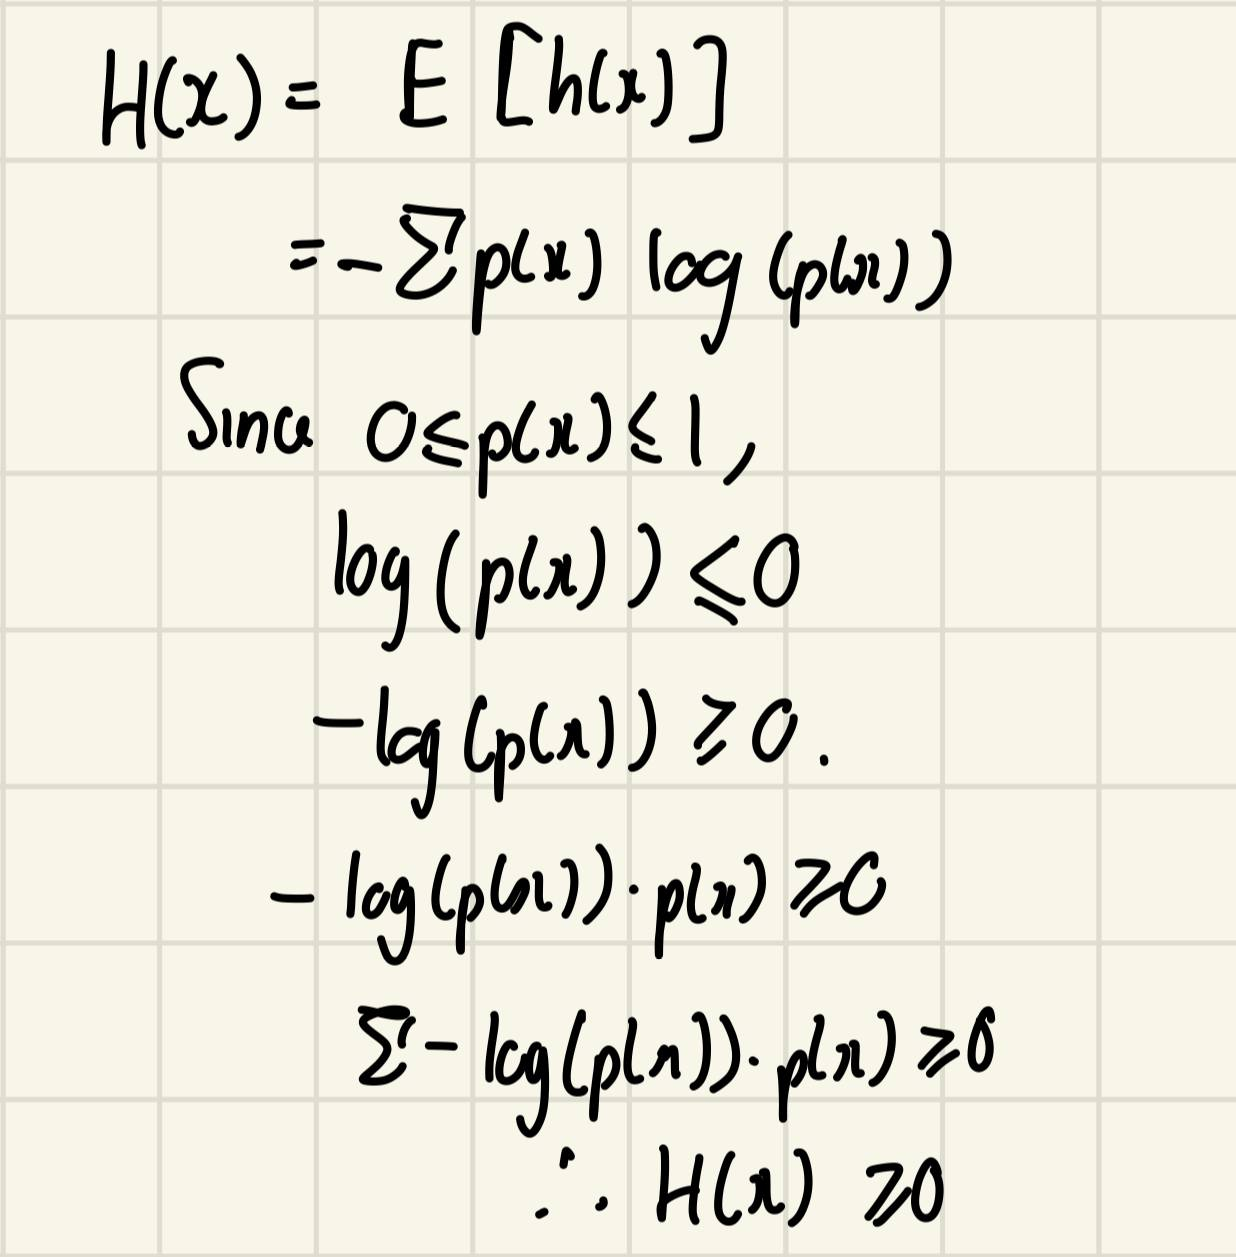


### The Kullback-Leibler divergence

Thus far we have only considered functions of a single distribution. In contrast, the _Kullback-Liebler divergence_ or _relative entropy_ (often abbeviated KLD) is a function of two distributions $P$ and $Q$, that quantifies how much one differs from the other. The KLD in bits is given by
$$ D_{\mathrm{KL}}(P||Q)
= \sum_{\mathrm x\in \Omega} \left(P(\mathbf x=\mathrm x) \log_2 \frac{P(\mathbf x=\mathrm x)}{Q(\mathbf x=\mathrm x)} \right)
= \mathbb{E}_{P_{\mathbf x}}\left[\log_2 \frac{P(\mathbf x)}{Q(\mathbf x)}\right]$$

A few properties of the KLD are:
* It is zero if $P$ and $Q$ are the same distribution
* It is greater than zero if $P$ and $Q$ are not same distribution
* It is asymmetric: the _forward_ KLD $D_{\mathrm{KL}}(P||Q)$ does not equal the _reverse_ KLD $D_{\mathrm{KL}}(Q||P)$ in general

**8.1.8 Task:**<br/>
Implement the function `kl_divergence_discrete` that computes $D_{\mathrm{KL}}(P||Q)$ in bits between `p` and `q`, where `p` and `q` are `np.array`s of the same length that describe two distributions (i.e., they list the probabilities of each outcome, in order). <font color="red"> (1 point) </font>

_Important:_<br/>
Use `np.where`, like you did above, to avoid issues if $P(\mathbf x=\mathrm x)=0$ for any $\mathrm x$.

_Hint:_<br/>
You can assume that `p` and `q` both are nonnegative and sum to one; no error checking needed.

In [ ]:
def kl_divergence_discrete(p, q):
    with np.errstate(all='ignore'):
        # I wanted to consider the Q(x=x) = 0
        log_pq = np.where(p == 0, 0, np.log2(p / q))
        return sum(p * log_pq)

In [ ]:
assert not np.isnan(kl_divergence_discrete(np.array([0, 0, 0.7, 0.3]), np.array([0.1, 0.2, 0.4, 0.3]))), "Handle the case when any item of p is 0"

What happens if $P(\mathbf x=\mathrm x)>0$ but $Q(\mathbf x=\mathrm x)=0$ for some $\mathrm x$?

In [ ]:
kl_divergence_discrete(np.array([0.7, 0.3]), np.array([1, 0]))

The KLD can also be generalised to continuous distributions, in such a way that the previous properties still hold. The associated formulas (in bits) are
$$ D_{\mathrm{KL}}(P||Q)
= \int_{\Omega} \left(p_{\boldsymbol x}(x) \log_2 \frac{p_{\boldsymbol x}(x)}{q_{\boldsymbol x}(x)} \right) \mathrm dx
= \mathbb{E}_{p_{\boldsymbol x}}\left[\log_2 \frac{p_{\boldsymbol x}(\boldsymbol x)}{q_{\boldsymbol x}(\boldsymbol x)}\right]$$

Below is a pre-implemented function `kl_divergence_continous` that uses Riemann integration (with step size `bin_width`) to compute an approximate KLD between two densities evaluated at the same, equidistant points.

In [ ]:
def kl_divergence_continous(dist1, dist2, bin_width):
    # We make sure that the dist1 and dist2 are probability distributions so they should integrate to 1
    # Think how Riemann integral works? We approximate values with rectangles whose width tends to 0
    # In our case we have bin_width given as parameter and the height of the bins are given by dist1 and dist2
    if not all([np.isclose(dist2.sum() * bin_width, 1, atol=1e-2), np.isclose(dist1.sum() * bin_width, 1, atol=1e-2)]):
        warnings.warn("One of the input distributions has significant probability mass outside the area specified in the problem thus the KL divergence might be incorrect.")

    # Normalize the distribution to sum to 1 and name them p and q
    p = dist1 * bin_width
    q = dist2 * bin_width

    assert all([np.isclose(p.sum(), 1, atol=1e-1), np.isclose(q.sum(), 1, atol=1e-1)]), "One of the distribution does not sums to 1. or close to 1 upto one precision"

    return kl_divergence_discrete(p, q)

We now define a test problem where $p_{\boldsymbol x}(x)$ is a GMM, which we are trying to approximate using a Gaussian density $q_{\boldsymbol x}(x)$ with adjustable mean $\mu$ and standard deviation $\sigma$.

In [ ]:
def gmm_vs_gauss_kld(mu=None, sigma=None):

    # Data distribution P(z)
    begin, end= -15, 15
    x = np.linspace(begin, end, 1000)
    bin_width = x[1] - x[0]
    norm1 = stats.norm.pdf(x, loc=3, scale=1)
    norm2 = stats.norm.pdf(x, loc=-3, scale=1)
    p_z = (norm1 + norm2) / 2

    fig, axis = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    title_all = ["Forward KL Divergence", "Reverse KL Divergence"]
    reverse_KL = [False, True]

    for i, ax in enumerate(axis):

        ax.plot(x, p_z, label="$P(z)$")
        ax.set_xticks(np.arange(begin, end))
        ax.fill_between(x, p_z, alpha=0.3)
        title = title_all[i]

        if mu is not None and sigma is not None:
            assert isinstance(mu, (int, float)) and isinstance(sigma, (int, float)), "Inputs should be numbers."
            assert begin <= mu <= end, f"Mean should be between {begin} and {end}. as we are integrating over this area if the probability mass will go beyond these points, the integral of probability will not sum to 1."

            q_z = stats.norm.pdf(x, loc=mu, scale=sigma)
            ax.plot(x, q_z, label="$Q(z)$")
            ax.fill_between(x, q_z, alpha=0.3)
            kl_div = kl_divergence_continous(p_z, q_z, x[1] - x[0]) if not reverse_KL[i] else kl_divergence_continous(q_z, p_z, x[1] - x[0])
            title += f" $KL(P||Q)$ = {kl_div: .2f}" if not reverse_KL[i] else f" $KL(Q||P)$ = {kl_div: .2f}"

        ax.set_title(title)
        ax.legend()
    plt.show()

Since the GMM is non-Gaussian, the approximation will not be perfect, no matter what parameter values we choose for $q_{\boldsymbol x}(x)$. The KLD will never be zero. However, it is quite instructive to see what the best approximation looks like. What happens when we cannot be perfect?

**8.1.9 Task:**<br/>
The code below plots $p_{\boldsymbol x}(x)$ and $q_{\boldsymbol x}(x)$, and computes two different Kullback-Leibler divergences between them. Experiment with the values of `mu` and `sigma` for $q_{\boldsymbol x}$ until you identify values that make the _reverse KLD_ (bottom plot) as small as possible. <font color="red"> (1 point) </font>

In [ ]:
# Change the values of the variables mu and sigma here until you have a good solution
mu = 3
sigma = 1

gmm_vs_gauss_kld(mu, sigma)

This is known as _mode-seeking behaviour._

**8.1.10 Task:**<br/>
Experiment with the values of `mu` and `sigma` for $q_{\boldsymbol x}$ until you identify values that make the _forward KLD_ (top plot) as small as possible. <font color="red"> (1 point) </font>

In [ ]:
# Change the values of the variables mu and sigma here until you have a good solution
mu = 0
sigma = 3

gmm_vs_gauss_kld(mu, sigma)

This is called _mass-covering behaviour_.

When a parametric model is misspecified (as seen here) and cannot fit the true data, our objective function will decide how it behaves, i.e., in what way it “perfers to fail”. The two behviours above are especially common failure modes of probabilistic models. The case of forward-KLD minimisation, in particular, is a toy-problem analogue for what happens when we use maximum likelihood to (as is typical) fit a too simple model to a complicated real-world dataset: the model will become too broad and smeared out, compared to the true, underlying distribution. Lesson 8.2 makes this connection more precise, by showing that minimising the (empirical) forward KLD is _the same thing_ as MLE!

Awareness of how probabilistic models behave under misspecification can be very useful in understanding how machine-learning methods perform in real world, and for choosing the right method for a given job. We will return to discuss these different behaviours in module 10 on data generation.

## 8.2 Decision trees (9.75 Points)

In this part of the exercise, you will be looking at implementing, training, and tuning decision trees. This process will make imporant use of concepts from information theory.

For ease of visualisation, we will work on a simple dataset in two dimensions. The data that we will use here is a adapted from the classic Iris dataset first used by Fisher in 1936, which contains measurements of the flowers of three different kinds of Iris plants. The Iris data is very commonly used as an example dataset in machine learning and statistics.

Our first step, as always, is to load the data into memory.

In [ ]:
# Loading dataset
iris = load_iris()
columns=['sepal_length', 'sepal_width', 'label']
dataset = pd.DataFrame(np.column_stack((iris.data[:, :2], iris.target)),
                       columns=columns)
dataset['label'] = dataset['label'].astype(np.int32)
dataset_train, dataset_val = train_test_split(dataset, test_size=20, random_state=1234)

Whenever you are confronted with a new dataset, it is usually a good idea to try to understand what is going on inside it. We have included code below that prints the dimensions of the data and plots a small visualisation.

In [ ]:
print(f"Train set: {dataset_train.shape}\tTest set: {dataset_val.shape}")

# A small visualisation of the dataset
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(data=dataset_train, x=columns[0], y=columns[1], hue='label', ax=ax[0])
ax[0].set_title('Train set')
sns.scatterplot(data=dataset_val, x=columns[0], y=columns[1],ax=ax[1], hue='label')
ax[1].set_title('Validation set')
fig.suptitle('Visualising the dataset')
plt.show()

Looking at the information above we can see:
* There are 130 points in the training data and 20 in the validation data
* Each point is associated with three numbers; these turn out to be `sepal_length`, `sepal_width`, and a class `label`
* There are three different classes, labelled 0 through 2
* Class 0 can be separated out linearly using an oblique boundary, whereas classes 1 and 2 overlap in a more complicated way
* The sepal measurements have been quantised to one decimal, and it is possible that points in the scatterplot may be overlapping

### Decision-tree questions

As described in the lecture notes, the idea of decision trees is to partition the observation space $\Omega$ into decision regions by recursively splitting the space into smaller and smaller regions using axis-aligned splits. This can produce some quite complex-looking decision regions.

For a numerical feature, like those in the current dataset, an axis-aligned split can be seen as a question of the form “is feature $x_d$ bigger than the threshold value $t$?” Depending on the answer to the question (here “yes” or “no”), we might ask different follow-up questions, and so on until a decision is reached. This creates a tree structure where internal nodes are questions, edges are answers to questions, and leaf nodes are decisions.

Since each datapoint will lie in a decision region, and will have an answer to a question of the above type, we can view decision trees as not only partitioning the data space, but also as partitioning the dataset $\mathcal D$. We have visualised the effect of splitting the data based on `sepal_length` for three different possible threshold values.

***Something to think about:***
Are decision trees low-variance or high-variance methods, in terms of the bias-variance trade off?

In [ ]:
sns.lmplot(data=dataset_train, x=columns[0], y=columns[1], hue='label', fit_reg=False, aspect=1.5, legend=False)
y_min, y_max = dataset_val.iloc[:, 1].min() - 1, dataset_val.iloc[:, 1].max() + 1
plt.vlines(5, ymin=y_min, ymax=y_max, label="Q1: Is sepal_length > 5?", colors='r')
plt.vlines(6, ymin=y_min, ymax=y_max, label="Q2: Is sepal_length > 6?", colors='k')
plt.vlines(7, ymin=y_min, ymax=y_max, label="Q3: Is sepal_length > 7?", color='b')
plt.title('Examples of questions for a decision tree')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Below is an implementation of Python class that represents a question that we can use to partition the dataset and (soon) build decision trees.

In [ ]:
class Question:
    """Ask a question to partition the dataset"""
    columns = columns

    def __init__(self, column, value):
        assert column in [0, 1], "A question can only be asked only on first and second column of the dataframe"
        self.column = column
        self.value = value

    def answer(self, datapoints):
        values = datapoints[self.column]
        return values >= self.value

    def __repr__(self):
        return f"Is {Question.columns[self.column]} >= {self.value}"

The code below illustrates how this class can be used to create question objects and compute the answers to these questions for a datapoint.

In [ ]:
# Let's ask these four questions
q1 = Question(0, 5)
q2 = Question(0, 6)
q3 = Question(0, 7)
q4 = Question(1, 2)

# These lines print the answer to the questions for the first point in the training data
datapoint = dataset_train.values[0]
print(f"Datapoint: {list(zip(Question.columns, datapoint))[:-1]}")
print(f"{q1}\t{q1.answer(datapoint)}")
print(f"{q2}\t{q2.answer(datapoint)}")
print(f"{q3}\t{q3.answer(datapoint)}")
print(f"{q4}\t{q4.answer(datapoint)}")

**8.2.1 Task:**<br/>
Create a variable `q` that expresses the question “Is `sepal_width >= 3`?” <font color="red"> (1 point) </font>

In [ ]:
q = Question(1, 3)
print(q)

In [ ]:
assert q.answer(np.array([1.2, 5])), f"Wrong question asked check the problem description and this '{q}'."
assert not q.answer(np.array([7.3, 2])), f"Wrong question asked check the problem description and this '{q}'."

***Something to think about:***

What are some problems that are particularly ill-suited for decision-tree learning? What do these problems have in common?


### Implementing decision tree basics

Throughout this exercise, we will gradually build an implementation of decision trees. Most of the code is already provided for you, but you will be asked to contribute some key pieces.

First, we provide a number of pre-implemented basic functions and helper code.

In [ ]:
# These are helper functions. Please do not modify.

class Leaf:
    """
    A Leaf node used to classify the data

    This holds a dictionary {1: x} where x is number of times
    it appears in the rows from the training data that reach this leaf.
    """
    def __init__(self, rows, depth):
        self.predictions = dict(Counter(rows[:, -1]))
        self.depth = depth
        label = str(self.leaf_text())
        self.visualize = pydot.Node(label+'-'+str(depth)+'-'+str(uuid4()), label=label, style="filled", fillcolor="greenyellow", shape='ellipse')

    def leaf_text(self):
        total = sum(self.predictions.values()) * 1.0
        output = []
        for lbl in self.predictions.keys():
            output.append(f"{int(lbl):d}={int(self.predictions[lbl] / total * 100):d}%")
        return ";".join(output)


class Decision_Node:
    """
    Has a reference to the question, left sub tree and right sub tree.
    """
    def __init__(self,
                 question,
                 true_branch,
                 false_branch,
                 depth):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.depth = depth
        label = str(question)
        self.visualize = pydot.Node(label+'-'+str(depth)+'-'+str(uuid4()), label=label, shape="rectangle", fillcolor="azure2", style="filled")


class DecisionTree:
    """
    Main decision tree class we will be adding more methods to it in the further parts of the assignement
    """
    def __init__(self, n_features=2, n_classes=3, max_depth=10, split_function=None):
        super(DecisionTree, self).__init__()
        assert max_depth > 0, '"Be like a tree. Stay grounded, keep growing, and know when to let go." - Buddha. Also, the depth must be greater than 0.'
        self.max_depth = max_depth
        self.n_features = n_features
        self.n_classes = 3
        self.tree = None
        self.pydot_tree = pydot.Dot("Decision Tree", label="Decision Tree", graph_type="digraph", strict=True, splines='line')
        self.split_function = split_function

    def fit(self, rows):

        if not hasattr(self, 'build_tree'):
            AttributeError("Method build_tree is not defined yet! Keep following the exercise to define it")

        if isinstance(rows, pd.DataFrame):
            rows = rows.values

        self.tree = self.build_tree(rows, 0)
        self.generate_pydot_tree(self.tree, None, None)


    def predict(self, rows):
        if isinstance(rows, pd.DataFrame):
            rows = rows.values

        predictions = []
        for row in rows:
            key = list(self.predict_row(row, self.tree).keys())[0]
            predictions.append(key)

        return np.array(predictions)


    def generate_pydot_tree(self, node, parent_node, edge_label):
        self.pydot_tree.add_node(node.visualize)

        if isinstance(node, Leaf):
            self.pydot_tree.add_edge(pydot.Edge(parent_node.visualize, node.visualize, label=edge_label))
            return

        if parent_node is not None:
            self.pydot_tree.add_edge(pydot.Edge(parent_node.visualize, node.visualize, label=edge_label))

        self.generate_pydot_tree(node.true_branch, node, 'True')
        self.generate_pydot_tree(node.false_branch, node, 'False')

    def visualize_tree(self):
        plt = Image(self.pydot_tree.create_png())
        display(plt)

    def visualize_decision_boundary(self, rows=None, plot_step=0.02, alpha=0.1, title="Decision boundary of the tree"):

        if rows is None:
            raise ValueError(r"Either pass 'rows=dataset_train' or 'rows=dataset_test' to " +
                       "visualize the decision boundary and get insights on how the tree is fitting the data.")

        rows_df = rows
        if isinstance(rows, pd.DataFrame):
            rows = rows.values

        delta = 0.25
        x_min, x_max = rows[:, 0].min() - delta, rows[:, 0].max() + delta
        y_min, y_max = rows[:, 1].min() - delta, rows[:, 1].max() + delta
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        fig, ax = plt.subplots(figsize=(10, 6))
        cs = ax.contourf(xx, yy, Z, cmap='coolwarm_r', alpha=alpha)
        plt.axis("tight")

        ax.set_title(title)
        sns.scatterplot(data=rows_df, x=Question.columns[0], y=Question.columns[1], hue='label', ax=ax)
        plt.show()


Next, we implement the part of the code that partitions a set of datapoints according to whether the answer to a given question is `True` or `False`.

**8.2.2 Task:**<br/>
Implement the `partitioning` function below. Aside from `self`, the function takes two inputs: <font color="red"> (1 point) </font>
* `rows`: An `np.array` of datapoints, one per row
* `question`: A `Question` object, that will de used to split the data in `rows`
The function should return a tuple of two outputs:
* `true_rows`: All rows in `rows` for which the answer to `question` is `True`
* `false_rows`: All rows in `rows` for which the answer to `question` is `False`

In [ ]:
def partitioning(self, rows, question):
    # This is actually a redundant code I kept in due to original formats
    true_rows, false_rows = [], []
    # Converts the list comprehension list into numpy array
    mask = np.array([question.answer(row) for row in rows])

    # Uses indexing to find the correct elements
    true_rows = rows[mask]
    false_rows = rows[~mask]
    return np.array(true_rows), np.array(false_rows)
# Reinitialise the tree with the new method added
DecisionTree.partitioning = partitioning
decision_tree = DecisionTree()

In [ ]:
# Run pre-specified tests (do not edit)
greater_than_5, less_than_5 = partitioning(decision_tree, np.arange(10).reshape(5, 2), Question(1, 5))
print(f"Greater than 5: \n{greater_than_5}")
print(f"Less than 5: \n{less_than_5}")
assert (greater_than_5.shape == (3, 2) and less_than_5.shape == (2, 2))

### Deciding which question to ask

To decide which question to ask, decision trees evaluate which of the possible questions that most effectively separate the classes in the current set of datapoints. If a question perfectly separates all classes in the data (which only can happen if the datapoints belong to at most two classes) it is clearly a good chocie, but if doesn't perfectly separate the classes, we will need some sort of measure of how close a partitioning is to perfect separation.

We will now look at two measures of how good a partitioning is:
* Information gain
* The Gini impurity

### Information gain

The information gain is based on the classic Shannon entropy, computed over the distribution of class labels. We will need to implement that first.
***Something to think about:***
Is maximising the information gain in decision-tree learning equivalent to minimising the Shannon entropy loss function?

**8.2.3 Task:**<br/>
Implement the `entropy` function for decision trees below. Note that each row in `rows` is a datapoint, and the label is the last element of the row. <font color="red"> (1 point) </font>

_Note:_<br/>
This function needs to compute multiclass entropy. As a consequence, the entopy of the label distribution can exceed 1 bit, since we might need more than one bit to encode three different possibilities. Compare with the numbers 0 through 2 written in binary, `00`, `01`, `10`, which clearly need more than a single bit to be expressed.

In [ ]:
def entropy(rows):
    """
    Returns the entropy of the distribution of labels in rows.
    Remember to handle the np.log2(0) case, for instance using np.where
    """
    # Distribution of labels from the rows
    labels, counts = np.unique(rows, return_counts=True)
    total_counts = sum(counts)
    probabilities = counts / total_counts
    content = np.where(probabilities == 0, 0, information_content(probabilities))
    return sum(probabilities * content)

# Reinitialise the tree with the new method
decision_tree = DecisionTree(split_function=entropy)

In [ ]:
# Run pre-specified tests (do not edit)
assert decision_tree.split_function(np.zeros((10, 1))) == 0.0, "The entropy of a dataset where everything has the same class should be 0"
assert decision_tree.split_function(np.vstack((np.full((5, 1), 1), np.full((5, 1), 0)))) == 1.0, "The entropy of an equal number of examples from two classes should be 1"

A good question to ask in the decision tree is one that reduces the uncertainty regarding the label of an instance, i.e., one that reduces the entropy between the classes. We can see this idea of greedily trying to minimise the overall entropy as fast as possible as an instance of using the entropy as a loss function for the decision tree.

A way to address this is to look at how much the entropy changes (decreases) after a particular split, compared to its value before the split. The prior entopy minus the new entropy is known as the _information gain_.

We will now define information gain in a more mathematical manner: Let $\{\mathcal Y_1,\mathcal Y_1\}$ be a partition of the labels $\mathcal Y =\{\mathcal y_i\}_{i=1}^n$. Let $P(\mathbf y \in \mathbf Y_2|\mathrm y \in \mathcal Y)=p_1$ denote the probability that an element selected uniformly at random from $\mathcal Y$ is a member of $\mathcal Y_1$, and introduce the similarly probability $p_2=1-p_1$ for $\mathcal Y_2$. If we define a random variable $\mathbf s$ (for split) that has $P(\mathbf s=1)=p_1$ and $P(\mathbf s=2)=p_2$, we can write the information gain using an expected value over the entropies of the two partitions:
$$\mathrm{IG}(\mathcal Y_1,\mathcal Y_2) = H(\mathcal Y) - \mathbb E_{P_{\mathbf s}}[H(\mathcal Y_{\mathbf s})]$$
In a sense, this is just the difference in expected (loss) before and after the particitioning.

We can expand the expression for information gain into a more concrete and easy-to-implement formula as
$$\mathrm{IG}(\mathcal Y_1,\mathcal Y_2) = H(\mathcal Y) - p_1 \cdot H(\mathcal Y_1) -  p_2 \cdot H(\mathcal Y_2)\\
= H(\mathcal Y_1 \cup \mathcal Y_2) - \frac{|\mathcal Y_1|}{|\mathcal Y_1 \cup \mathcal Y_2|} H(\mathcal Y_1) - \frac{|\mathcal Y_2|}{|\mathcal Y_1 \cup \mathcal Y_2|} H(\mathcal Y_2)$$
where $|\mathcal Y|$ is the total number of elements in $\mathcal Y$.

**8.2.4 Task:**<br/>
Implement the `improvement` function below, which measures how much the loss function improves from a given partitioning. Aside from `self` the inputs are:
* `left`: A partition of datapoints (a.k.a. rows) corresponding to $\mathcal Y_1$.
* `right`: A partition of datapoints (a.k.a. rows) corresponding to $\mathcal Y_2$
* `current_uncertainty`: The entropy $H(\mathcal Y)$ of (the distribution of the labels in) the union of the partitions.

The function returns a single number, namely the information gain $\mathrm{IG}(\mathcal Y_1,\mathcal Y_2)$ of the partitioning. <font color="red"> (1 point) </font>

_Important:_<br/>
You can access the `entropy` function that you implemented above as `self.split_function`. Please use the latter, instead of calling `entropy` directly, since it makes the code generalise to other splitting functions that we will consider later on.

In [ ]:
def improvement(self, left, right, current_uncertainty):
    """
    Return the improvement to the loss function gained from the left-right partitioning.
    """
    left_size = len(left)
    right_size = len(right)
    total_size = left_size + right_size
    return current_uncertainty - (left_size * self.split_function(left) + right_size * self.split_function(right)) / total_size

# Reinitialise the tree with the new method added
DecisionTree.improvement = improvement
decision_tree = DecisionTree(split_function=entropy)

In [ ]:
# Run pre-specified tests (do not edit)
left, right = np.vstack((np.full((3, 1), 0), np.full((3, 1), 1))), np.full((5, 1), 1)
assert np.isclose(decision_tree.improvement(left, right, 0.5), -0.045, atol=1e-2), "Wrong value of improvement please check the implementation again"
left, right = np.vstack((np.full((10, 1), 0), np.full((3, 1), 1))), np.full((15, 1), 1)
assert np.isclose(decision_tree.improvement(left, right, 0.3), -0.061, atol=1e-2), "Wrong value of improvement please check the implementation again"

### Gini impurity

Another common measure of how good a decision tree is the _Gini impurity_ of a leaf node (i.e., a set of datapoints). This should not be confused with the Gini _coefficient_ from economics; they're just named after the same person.

The Gini impurity can be seen as the answer to the question “If randomly guess labels according to the a priori distribution on this dataset, what misclassification rate will I get?” If we let $\mathbf y$ be a label drawn uniformly at random from $\mathcal Y$, then we have
$$P(\mathbf y=\mathrm y)=\pi_{\mathrm y}=\frac{n_{\mathrm y}}{n}$$
where $n_{\mathrm y}$ is the number of instances in $\mathcal Y$ that equal $\mathrm y$. We can then write
$$ G(\mathcal Y)
= \sum_{\mathrm y=1}^k \pi_{\mathrm y} (1 - \pi_{\mathrm y})
= \mathbb E_{P_{\mathbf y}}[(1-P(\mathbf y=\mathrm y))]$$

If we look at the above expression, it is quite similar to the expression for the (Shannon) entropy
$$ H(\mathcal Y)
= \sum_{\mathrm y=1}^k \pi_{\mathrm y} (-\log_2\pi_{\mathrm y})
= \mathbb E_{P_{\mathbf y}}[(-\log_2 P(\mathbf y=\mathrm y))]$$
The Gini impurity just replaces $-\log_2\pi_{\mathrm y}$ in this expectation with $1 - \pi_{\mathrm y}$. Both of these are decreasing functions that reach zero when $\pi_{\mathrm y}=1$.
_We can view the Gini impurity as another measure of entropy, i.e., uncertainty._

For a Bernoulli random variable, the Gini impurity corresponds to replacing the function for the entropy of a single coin toss, which is almost-but-not-quite a parabola, with an actual parabola. Another name for this function is the _Tsallis entropy of index 2_. This quantity does not have all of the appealing theoretical properties of the classic Shannon entropy, but it is quite close, and it might even work better in certain scenarios, since the Tsallis entopy is less sensitive to changes to the probability of rare events, compared to the Shannon entropy.

To compute the Gini impurity in practice, we can simplify the previous expression slightly
$$ G(\mathcal Y)
= \sum_{\mathrm y=1}^k \pi_{\mathrm y} (1 - \pi_{\mathrm y})
= \sum_{\mathrm y=1}^k \pi_{\mathrm y} - \sum_{\mathrm y=1}^k\pi_{\mathrm y}^2
= 1 - \sum_{\mathrm y=1}^k\pi_{\mathrm y}^2$$

**8.2.5 Task:**<br/>
Implement the `gini` function for decision trees below. Note that each row in `rows` is a datapoint, and the label is the last element of the row. <font color="red"> (1 point) </font>

In [ ]:
def gini(rows):
    """Return the Gini impurity for a collection of datapoints."""
    counts = dict(Counter(rows[:, -1]))
    total_counts = sum(counts.values())
    probabilities_sum = 0
    for label in counts:
      probabilities_sum += (counts[label] / total_counts)**2
    impurity = 1 - probabilities_sum
    return impurity

# Reinitialise the tree with the new method
decision_tree = DecisionTree(split_function=gini)

In [ ]:
# Run pre-specified tests (do not edit)
assert decision_tree.split_function(np.zeros((10, 1))) == 0.0, "The Gini impurity of a dataset where everything has the same class should be 0"
assert decision_tree.split_function(np.vstack((np.full((5, 1), 1), np.full((5, 1), 0)))) == 0.5, "The Gini impurity of an equal number of examples from two classes should be 0.5"

We can now use this function instead of $H(\mathcal Y)$ as a loss function for building decision trees, and try to find the spilts that reduce the expected value of $G(\mathcal Y)$.

As a small example, how much does the Gini impurity decrease if using our previous question `q` using the loss `func=gini`?

In [ ]:
current_uncertainity = gini(dataset_train.values)
print(f"Current uncertainity:\t{current_uncertainity: .3f}")
petal_width_above, petal_width_below = partitioning(decision_tree, dataset_train.values, q)
information_gain = improvement(decision_tree, petal_width_above, petal_width_below, current_uncertainity)
print(f"Loss reduction:\t{information_gain: .3f} with the question '{q}'")
#print(f"After splitting left tree contains the classes {np.unique(petal_width_below[:, -1])} " +
#      f"and the right tree contains the classes {np.unique(petal_width_above[:, -1])}")

### Building the tree

What we need to do next on the roadmap toward decision trees is to consider all relevant splits, all relevant questions we can ask, and try to see which one of them that will decrease the loss the most. Normally, this would be done by binning every continuous-valued feature and then comparing the potential loss improvements from splitting the data along each bin boundary. However, since our dataset is already quantised to one decimal, it has already effectively been binned, and we can just iterate over all unique feature values in the data.

**8.2.6 Task:**<br>
Try to find the best split by iterating over all features (columns) and all rows (examples) in the dataset by implementing `find_best_split` below. For each feature, consider all possible threshold values that we can use when asking a question that splits the data based on that feature. Return the size of the best improvement that you found and the question that gave rise to it. <font color="red"> (1 point) </font>

_Hint:_
Use `self.partitioning` to split the rows according to a specific question and then use `self.improvement` to compute how much the loss improves (here called `gain`) due to the resulting split. Splits where either $\mathcal Y_1$ or $\mathcal Y_2$ end up empty can be ignored.

In [ ]:
def find_best_split(self, rows):
    best_gain = 0
    best_question = None
    current_uncertainty = self.split_function(rows)

    for col in range(self.n_features):  # for each feature
        values = set([row[col] for row in rows])  # unique values in the column
        for val in values:  # for each value
            question = Question(col, val)
            left, right = self.partitioning(rows, question)
            improvement = self.improvement(left, right, current_uncertainty)
            if improvement >= best_gain:
              best_gain = improvement
              best_question = question
    return best_gain, best_question

# Reinitialise the tree with the new method added
DecisionTree.find_best_split = find_best_split
decision_tree = DecisionTree(split_function=gini)

In [ ]:
dummy_data = np.array([
    [1, 2, 0],
    [2, 3, 0],
    [4, 5, 1],
    [4, 3, 1]
])

best_gain, best_question = find_best_split(decision_tree, dummy_data)
assert best_gain == 0.5, "The best gain does not seems to be correct"

We can now put together code that leverages the various functions we already have created, in order to recursively split the data to build a decision tree. For your convenience, this has already been done for you.

In [ ]:
def build_tree(self, rows, depth):
    """
    A recursive, depth-first way to build the tree.

    Rules of recursion:
        1) Believe that it works.
        2) Start by checking for the base case (no further information gain or max depth reached).
        3) Prepare for giant stack traces.
    """
    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = self.find_best_split(rows)

    # Base case: no further improvement or max depth reached
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0 or depth == self.max_depth:
        return Leaf(rows, depth)

    # If we reach this point, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = self.partitioning(rows, question)

    # Recursively build the true branch.
    true_branch = self.build_tree(true_rows, depth + 1)

    # Recursively build the false branch.
    false_branch = self.build_tree(false_rows, depth + 1)

    # Return a Question node.
    # This records the best feature / value to ask at this point
    # as well as the branches to follow
    # depending on the answer.
    return Decision_Node(question, true_branch, false_branch, depth)


# Reinitialise the tree with the new method added
DecisionTree.build_tree = build_tree
decision_tree = DecisionTree(split_function=entropy)

Let's use the code we have to build a tree on our training dataset (using `decision_tree.fit`). After that, we can visualise the tree we got using `decision_tree.visualize_tree()`:

In [ ]:
decision_tree.fit(dataset_train)
decision_tree.visualize_tree()

We still need to implement a function that takes new instances and predicts their class label. That function is provided below.

In [ ]:
def predict_row(self, row, node=None):
    """See the 'rules of recursion' above."""
    if node is None:
        node = self.tree

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.answer(row):
        return self.predict_row(row, node.true_branch)
    else:
        return self.predict_row(row, node.false_branch)


# Reinitialise the tree with the new method added
DecisionTree.predict_row = predict_row
decision_tree = DecisionTree(split_function=gini)
decision_tree.fit(dataset_train)

Let's see what predictions we get on the validation data, and check what macro $F_1$ score those predictions have. We can use the `f1_score` function (with suitable arguments) to compute the score.

In [ ]:
prediction = decision_tree.predict(dataset_val)
f1_score(prediction, dataset_val.values[:, -1], average='macro')

That's not perfect, but it's definitely above random chance (if not, there's a mistake somewhere).

Let's use `visualize_decision_boundary` to see what the decision regions for the three classes look like:

In [ ]:
decision_tree.visualize_decision_boundary(dataset_train)

Hmm. That looks a wee bit idiosyncratic.

Can we do better?

### Regularise the decision tree

The decision tree procedure we have been using thus far does not stop until it is nearly
100% accurate on training data. it should be pretty obvious that this can lead to overfitting.

There exists a large variety of different techniques that can be used to regularise decision-tree learning, with the goal of getting less overfitted trees that generalise better. Here we will be using a variant of early stopping, where we constrain the maximum depth of the tree. This means that we don't go on to recursively build subtrees for the child nodes if we already have reached a certain, maximum depth.

Below is code that runs our decision-tree learning with the maximum depth constrained to 5. In the visualisation of the resulting tree, note that not all branches go all the way to the maximum depth.

In [ ]:
decision_tree = DecisionTree(split_function=entropy, max_depth=5)
decision_tree.fit(dataset_train)
prediction = decision_tree.predict(dataset_val)
decision_tree.visualize_tree()
#accuracy_score(prediction, dataset_test.values[:, -1])

This should have given you a pretty decent idea of how decision trees work and what kind of decision regions they create. :)